[中国温度分布图，mask外部](https://blog.csdn.net/weixin_42372313/article/details/113705254)

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import numpy as np
import shapefile
import xarray as xr
import geopandas as gpd

In [3]:
p = r'/mnt/e/SHP/world_shp/world_adm0_Project.shp'
sf = shapefile.Reader(p)
sf

for shape_rec in sf.shapeRecords():
    #shape_rec.record内部存放了单一国家的很多信息，比如名字，货币等等
    #其中shape_rec.record[2]放的是国家名
    #可以print(shape_rec.record)看看
    print(shape_rec.record)

Record #0: ['Afghanistan', 'AFG', 'Asia']
Record #1: ['Albania', 'ALB', 'Europe']
Record #2: ['Algeria', 'DZA', 'NorthAfrica']
Record #3: ['Andorra', 'AND', 'Europe']
Record #4: ['Angola', 'AGO', 'Sub Saharan Africa']
Record #5: ['Antarctica', 'ATA', 'Antarctica']
Record #6: ['Antigua and Barbuda', 'ATG', 'Caribbean']
Record #7: ['Argentina', 'ARG', 'Latin America']
Record #8: ['Armenia', 'ARM', 'Asia']
Record #9: ['Australia', 'AUS', 'Australia']
Record #10: ['Austria', 'AUT', 'Europe']
Record #11: ['Azerbaijan', 'AZE', 'Asia']
Record #12: ['Bahamas, The', 'BHS', 'Caribbean']
Record #13: ['Bahrain', 'BHR', 'Asia']
Record #14: ['Bangladesh', 'BGD', 'Asia']
Record #15: ['Barbados', 'BRB', 'Caribbean']
Record #16: ['Belgium', 'BEL', 'Europe']
Record #17: ['Belize', 'BLZ', 'Latin America']
Record #18: ['Benin', 'BEN', 'Sub Saharan Africa']
Record #19: ['Bermuda', 'BMU', 'North America']
Record #20: ['Bhutan', 'BTN', 'Asia']
Record #21: ['Bolivia', 'BOL', 'Latin America']
Record #22: ['Bos

In [5]:
p = r'/mnt/e/SHP/gadm36_CHN_shp/gadm36_CHN_1.shp'
sf = shapefile.Reader(p)

for shape_rec in sf.shapeRecords():
    #shape_rec.record内部存放了单一国家的很多信息，比如名字，货币等等
    #其中shape_rec.record[2]放的是国家名
    #可以print(shape_rec.record)看看
    print(shape_rec.record)

Record #0: ['CHN', 'China', 'CHN.1_1', 'Anhui', 'Ānhuī', '安徽|安徽', 'Shěng', 'Province', '', 'CN.AH']
Record #1: ['CHN', 'China', 'CHN.2_1', 'Beijing', 'Běijīng', '北京|北京', 'Zhíxiáshì', 'Municipality', '', 'CN.BJ']
Record #2: ['CHN', 'China', 'CHN.3_1', 'Chongqing', 'Chóngqìng', '重慶|重庆', 'Zhíxiáshì', 'Municipality', '', 'CN.CQ']
Record #3: ['CHN', 'China', 'CHN.4_1', 'Fujian', 'Fújiàn', '福建', 'Shěng', 'Province', '', 'CN.FJ']
Record #4: ['CHN', 'China', 'CHN.5_1', 'Gansu', 'Gānsù', '甘肅|甘肃', 'Shěng', 'Province', '', 'CN.GS']
Record #5: ['CHN', 'China', 'CHN.6_1', 'Guangdong', 'Guǎngdōng', '廣東|广东', 'Shěng', 'Province', '', 'CN.GD']
Record #6: ['CHN', 'China', 'CHN.7_1', 'Guangxi', 'Guǎngxī Zhuàngzú', '廣西壯族自治區|广西壮族自治区', 'Zìzhìqu', 'Autonomous Region', '', 'CN.GX']
Record #7: ['CHN', 'China', 'CHN.8_1', 'Guizhou', 'Gùizhōu', '貴州|贵州', 'Shěng', 'Province', '', 'CN.GZ']
Record #8: ['CHN', 'China', 'CHN.9_1', 'Hainan', 'Hǎinán', '海南', 'Shěng', 'Province', '', 'CN.HA']
Record #9: ['CHN', 'China', 

#设置画布和绘图区
fig = plt.figure(figsize=[10,8], dpi=500)
ax = fig.add_subplot(111)

### def region_clip()函数注意事项
1. from matplotlib.path import Path
2. from matplotlib.patches import PathPatch
3. import shapefile
4. 函数需要传入ax
5. 每一个shp文件record次序不一样，需要注意

In [5]:
for shape_rec in sf.shapeRecords():
    #shape_rec.record内部存放了单一国家的很多信息，比如名字，货币等等
    #其中shape_rec.record[2]放的是国家名
    #可以print(shape_rec.record)看看
#     print(shape_rec.record)
    if shape_rec.record[0] == 'China':
        codes = []#用来存放移动路径(画图动作)
        #shape_rec.shape是一个类，图形类
        #里面三个属性shapeType：图形类型  points图形边界坐标  parts图形起始索引
        #解释一下parts属性，一个国家的边界可能不是全连在一起的，会分为一块一块，那么就相当于多个图形，存在shp文件内就不连续，parts里面就放了每个区域的起始索引（下标）
        pts = shape_rec.shape.points
        #上文已经说过了parts的意义，设想一下，两块区域的的起始坐标中间夹的不就是一块区域的所有坐标吗，但是最后一块区域没有结束值，所有加了[len(pts)]，这就是最后一个点的索引。
        prt = list(shape_rec.shape.parts) + [len(pts)]
        #下面的循环主要作用是：建立一个绘图路径，利用区块起始点的索引生成一个画图动作
        for i in range(len(prt) - 1):
            codes += [Path.MOVETO]#点移动
            codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)#画线
            codes += [Path.CLOSEPOLY]#这块画完，循环结束，下一块
        clip = Path(pts, codes)#利用数据和路径生成一个画图动作
        clip = PathPatch(clip, transform=ax.transData)#再加入ax的变换

def clip_CHN(ax):
    path = r'E:/SHP/world_shp/world_adm0_Project.shp' ##修改
    sf = shapefile.Reader(path)
    for shape_rec in sf.shapeRecords():
        if shape_rec.record[0] == 'China': ##修改
            codes = []  
            pts = shape_rec.shape.points
            prt = list(shape_rec.shape.parts) + [len(pts)]
            for i in range(len(prt) - 1):
                codes += [Path.MOVETO]
                codes += [Path.LINETO] * (prt[i+1] - prt[i] - 2)
                codes += [Path.CLOSEPOLY]  
            clip = Path(pts, codes) 
            clip = PathPatch(clip, transform=ax.transData) 
    return clip

In [6]:
ds = xr.open_dataset(r'G:/u119-tas1/tas_Amon_CAMS-CSM1-0_ssp119_r1i1p1f1.nc')
lat = ds.lat
lon = ds.lon
data = (ds['tas'][0,::-1,:] - 273.15) # 把温度转换为℃   [0,::-1,:]表示第一个时次、纬度反向
############################至此读取温度数据结束######################

#下面画
cbar_kwargs = {
    'orientation': 'horizontal',
    'label': 'Temperature (℃)',
    'shrink': 0.02,
    'ticks': np.arange(-25, 25 + 1, 5),
    'pad': -0.28,
    'shrink': 0.95
}

levels = np.arange(-25, 25 + 1, 1)


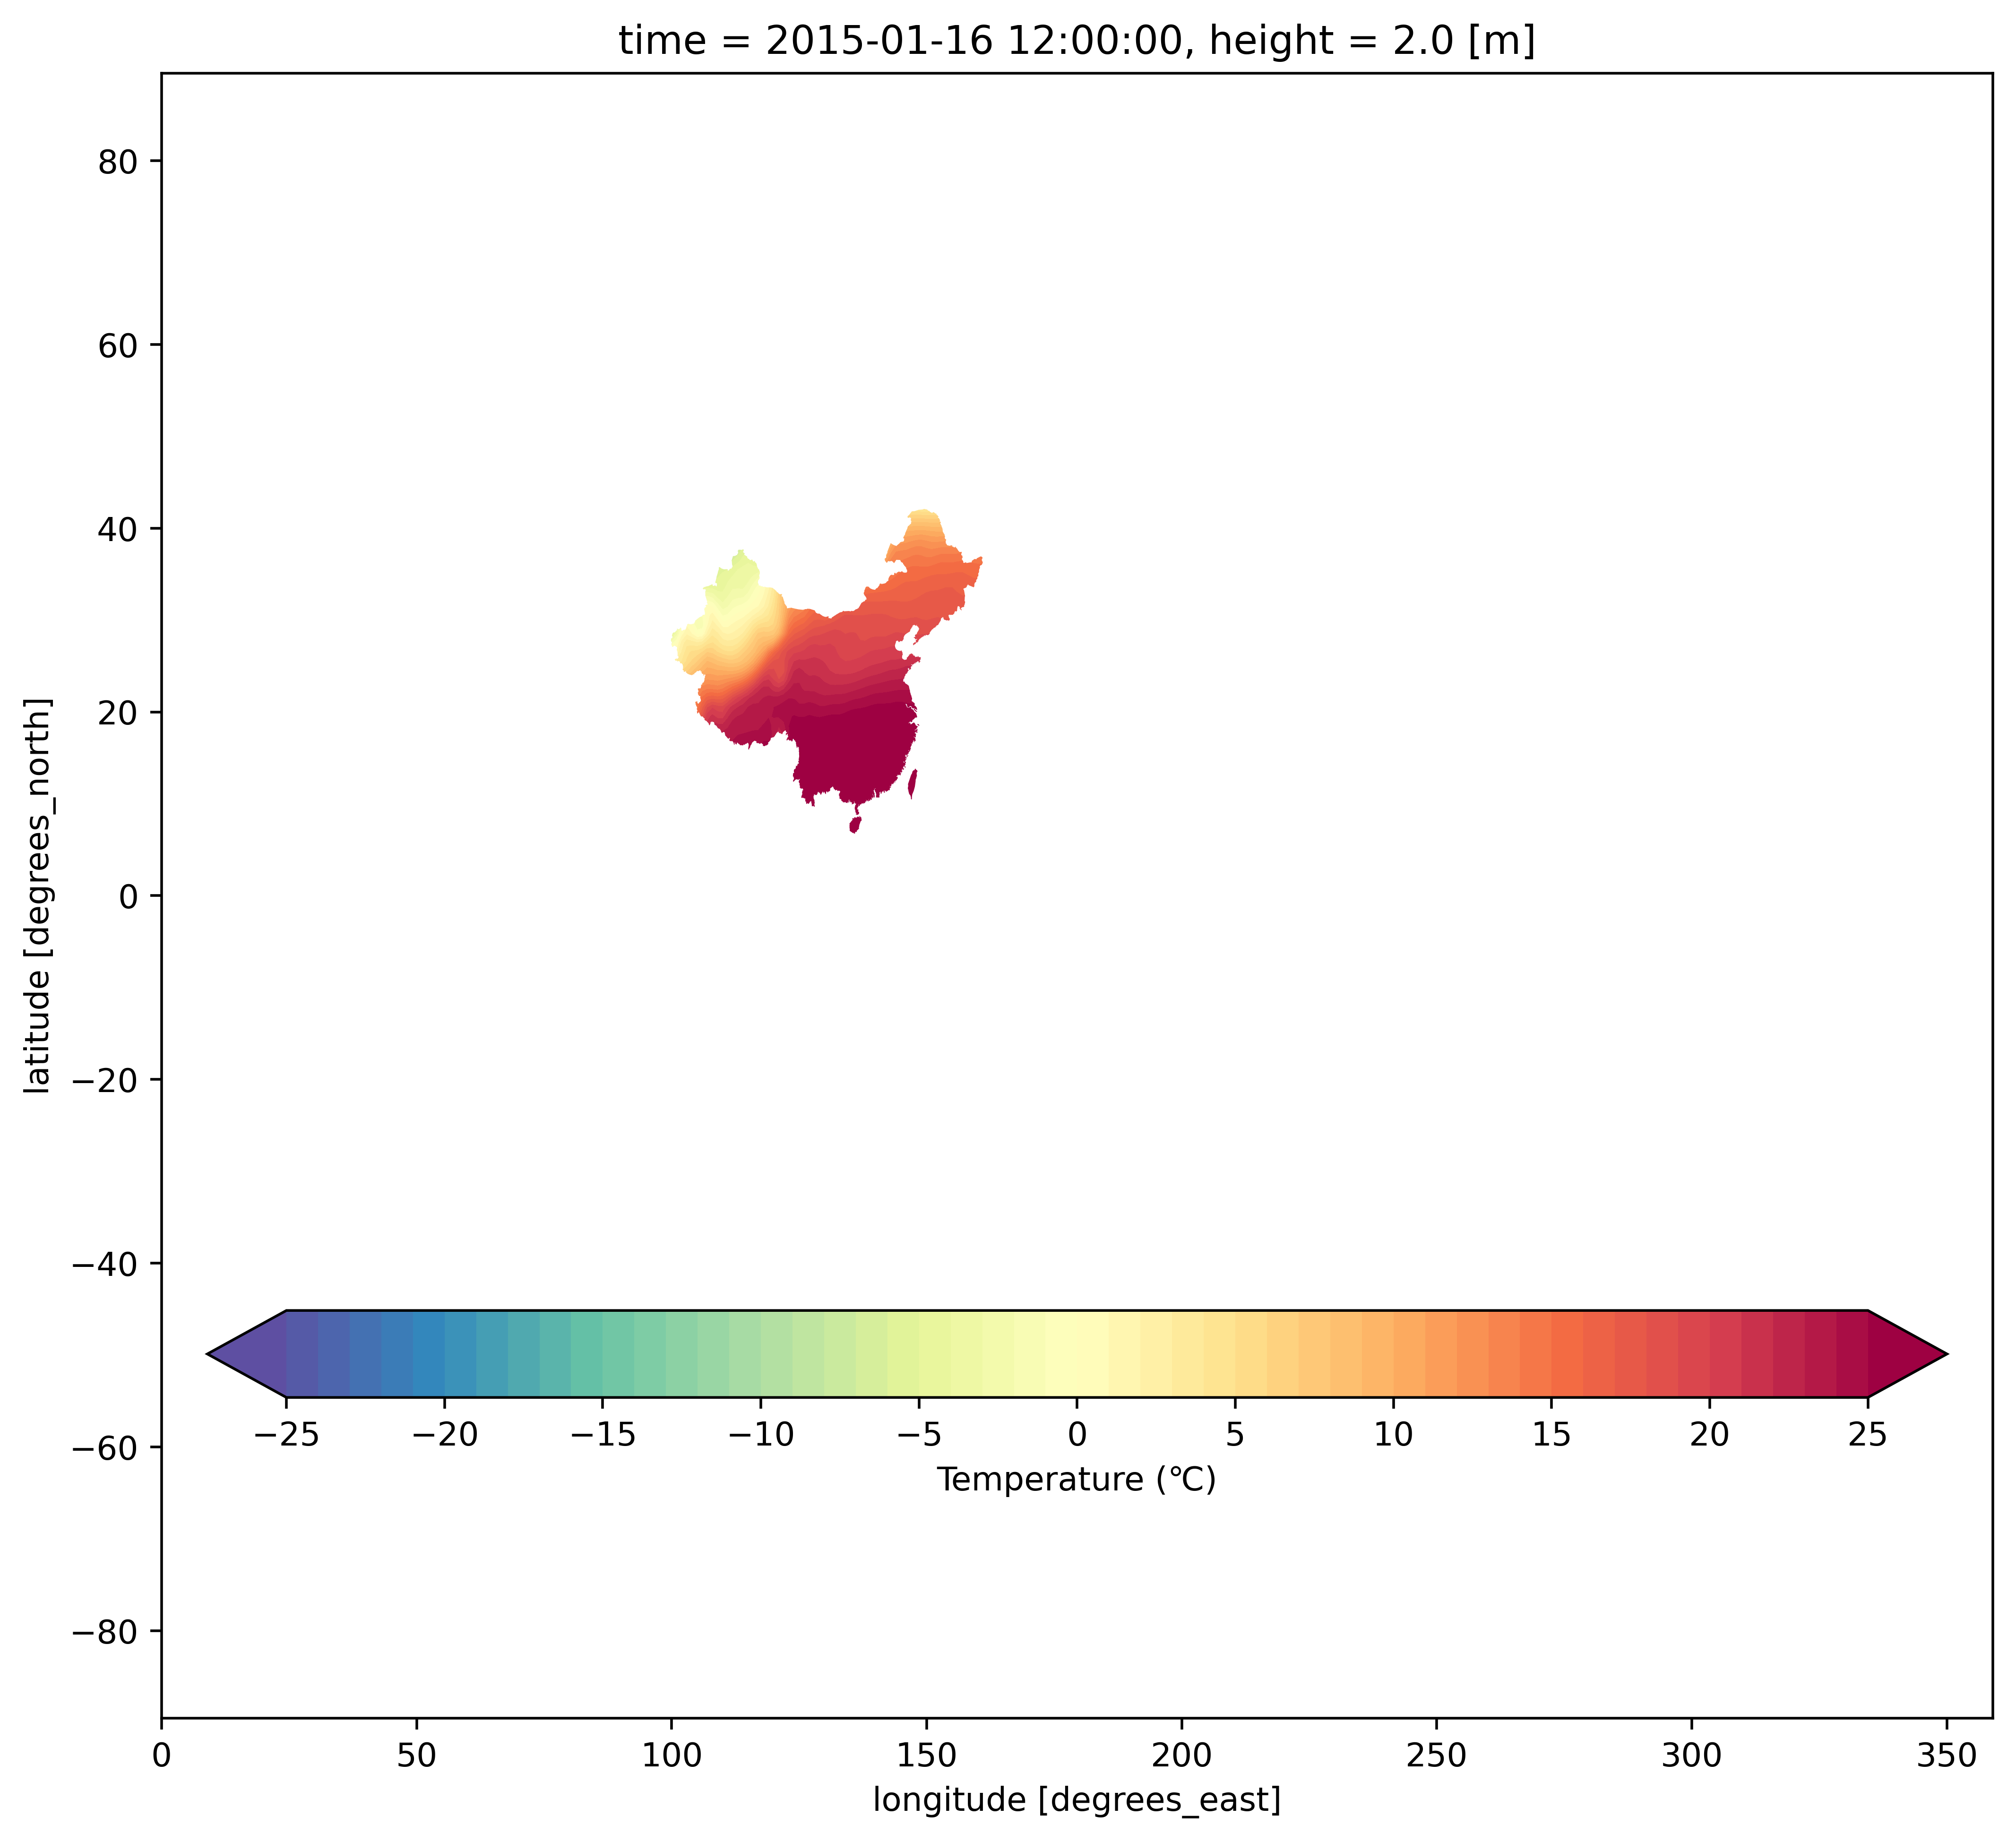

In [8]:
fig = plt.figure(figsize=[10,8], dpi=500)
ax = fig.add_subplot(111)
cs = data.plot.contourf(ax=ax,levels=levels,cbar_kwargs=cbar_kwargs, cmap='Spectral_r')
#添加掩膜路径，白化外部的分部
for contour in cs.collections:
    contour.set_clip_path(clip)
    
plt.show()